# Test data process (xyz + uv + normal)

In [3]:
import os
import sys

sys.path.insert(0, os.path.abspath('..'))

from data_process.geometry_utils.obj import read_obj

mesh_fp = '../resources/examples/0000/0000.obj'
mesh_obj = read_obj(mesh_fp)

print('*** verts: ', mesh_obj.points.shape, mesh_obj.points.max(axis=0), mesh_obj.points.min(axis=0))
print('*** uvs: ', mesh_obj.point_data['obj:vt'].shape, mesh_obj.point_data['obj:vt'].max(axis=0), mesh_obj.point_data['obj:vt'].min(axis=0))
print('*** normals: ', mesh_obj.point_data['obj:vn'].shape, mesh_obj.point_data['obj:vn'].max(axis=0), mesh_obj.point_data['obj:vn'].min(axis=0))


*** verts:  (143000, 3) [ 459.852 1550.2    229.994] [-458.214  103.119 -196.118]
*** uvs:  (143000, 3) [1431.89 1762.71    0.  ] [-2.96054e+03  2.90294e+02 -5.01000e-06]
*** normals:  (143000, 3) [0.999997 0.998641 0.999999] [-0.999998 -0.999894 -1.      ]


E:\lry\data\AIGP\demo_v2\Q1\objs\仅工程类\0304\张晓雯\A型小飞袖圆领荷叶边连衣裙
(10, 64, 64, 3) [ 0.00504922 -0.24544415  0.009965  ] 1.5091116
(63, 64, 3) (63, 64, 2)
*** surf_pnts:  [0.30347508 0.50911164 0.22094326] [-0.29337662 -1.         -0.20101325]
*** edge_pnts:  [0.3038553  0.5095093  0.22113527] [-0.29436278 -0.36606297 -0.20116568]
*** uv_offset:  (1, 2) [-0.27168867 -0.17978846] [-0.27168867 -0.17978846]
[_to_o3d_pc] color:  std::vector<Eigen::Vector3d> with 40960 elements.
Use numpy.asarray() to access data.
[_to_o3d_pc] color:  std::vector<Eigen::Vector3d> with 4032 elements.
Use numpy.asarray() to access data.


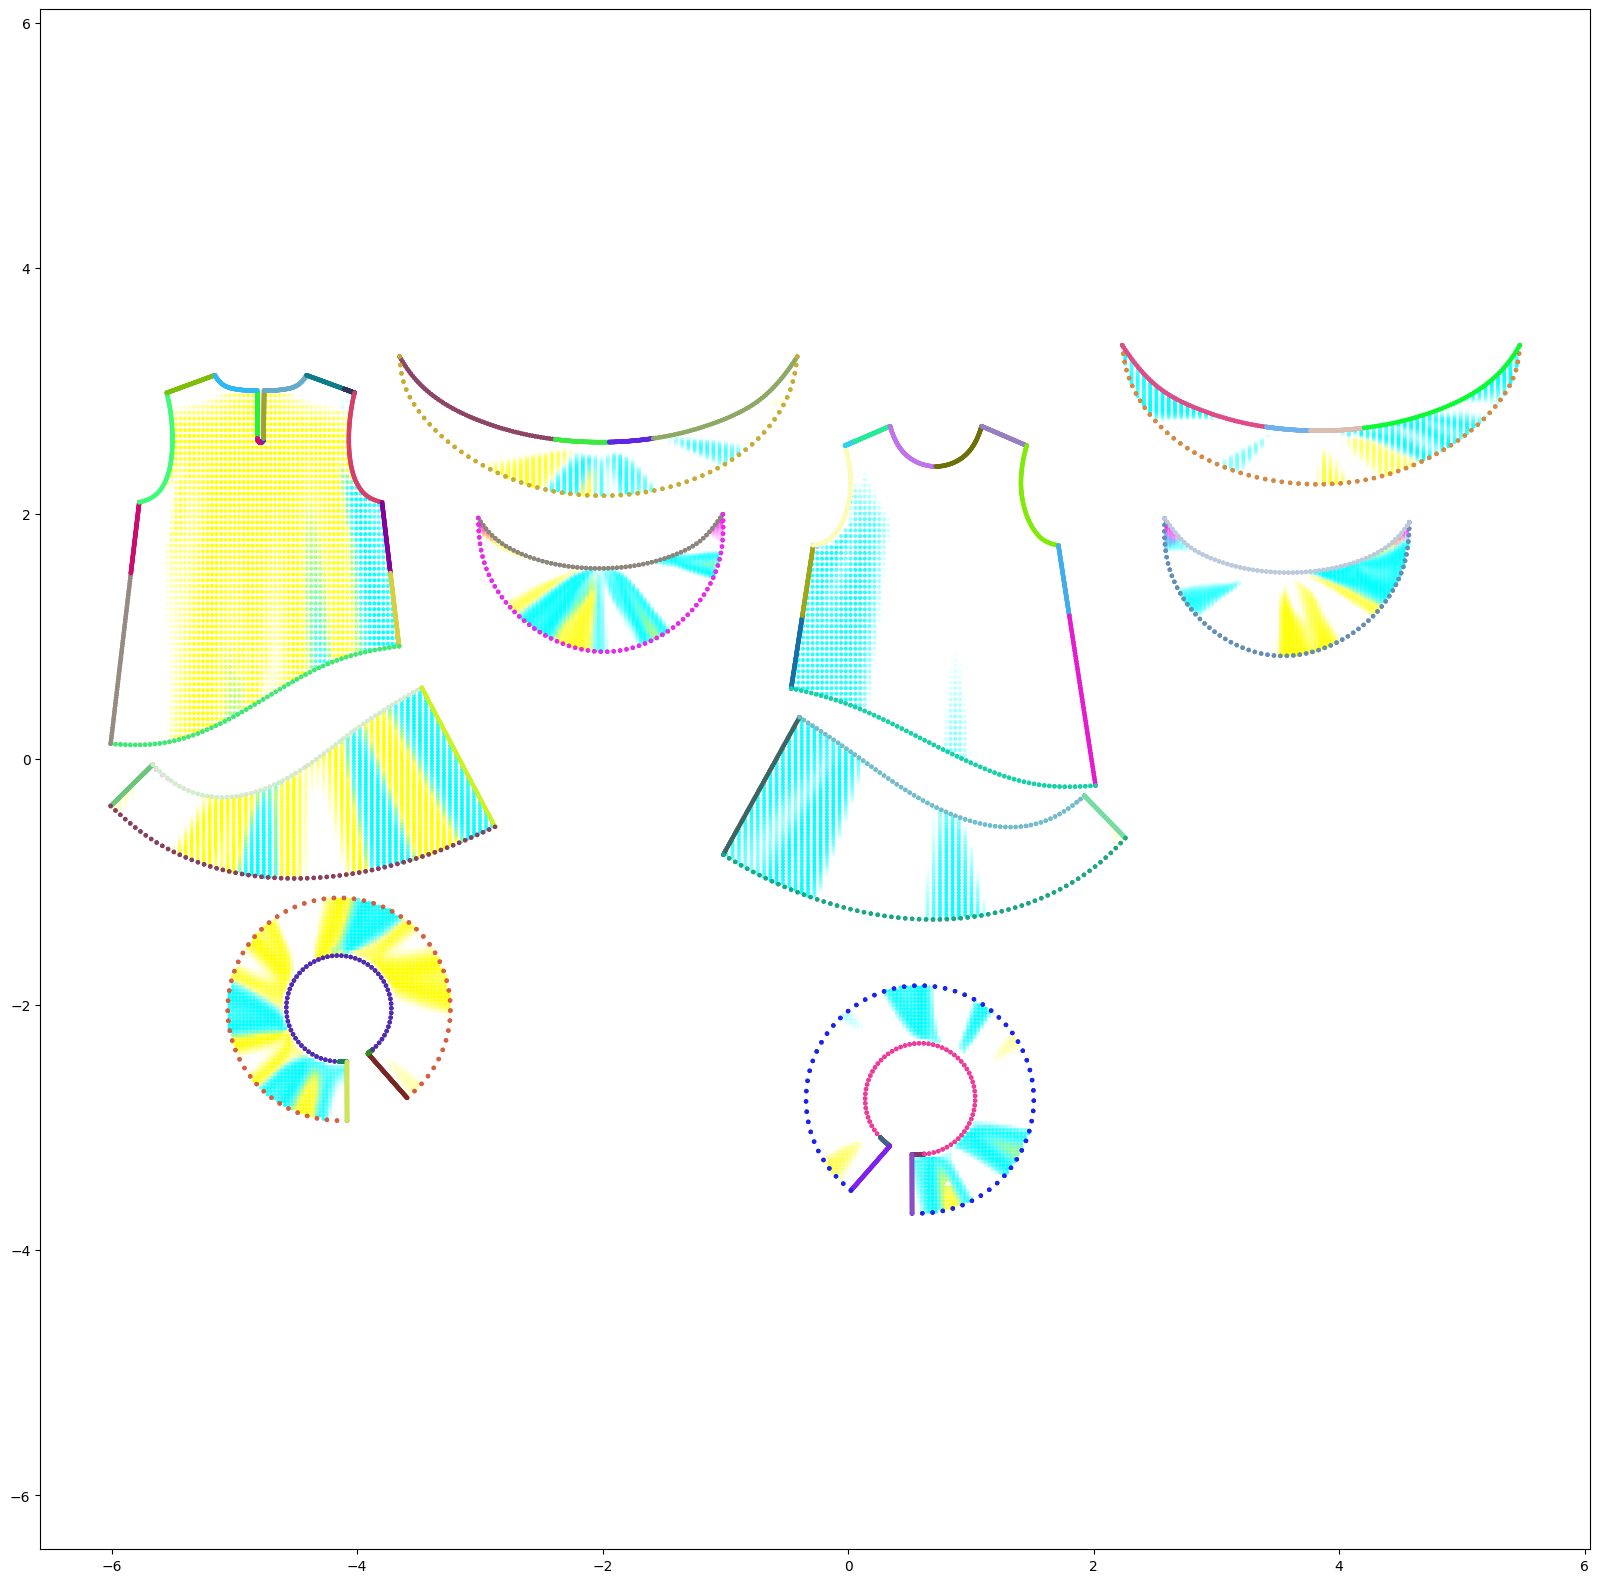

In [120]:
import os
import random
import pickle
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt

from glob import glob

def _to_o3d_pc(xyz: np.ndarray, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    print('[_to_o3d_pc] color: ', pcd.points)
        
    if color is not None:
        if len(color) != len(xyz): 
            color = np.array(color)[None].repeat(len(xyz), axis=0)
        pcd.colors = o3d.utility.Vector3dVector(color)

    return pcd

def _denormalize_pnts(pnt_wcs, offset, scale):
    return pnt_wcs * scale * 0.5 + offset
    
data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q1\\brep_test\\"
data_path = random.choice(glob(os.path.join(data_root, '*.pkl')))

with open(data_path, "rb") as tf: data = pickle.load(tf)

print(data['data_fp'])
print(data['surf_wcs'].shape, data['global_offset'], data['global_scale'])
print(data['edge_wcs'].shape, data['edge_uv_wcs'].shape)

global_offset = np.array(data['global_offset'])[None]
global_scale = data['global_scale']

uv_offset = data['uv_offset'][None]
uv_scale = data['uv_scale']

surf_pnts = data['surf_wcs'].reshape(-1, 3) * (global_scale * 0.5) + global_offset
edge_pnts = data['edge_wcs'].reshape(-1, 3) * (global_scale * 0.5) + global_offset

print('*** surf_pnts: ', surf_pnts.max(axis=0), surf_pnts.min(axis=0))
print('*** edge_pnts: ', edge_pnts.max(axis=0), edge_pnts.min(axis=0))
print('*** uv_offset: ', uv_offset.shape, uv_offset.max(axis=0), uv_offset.min(axis=0))

surf_uv = data['surf_uv_wcs'].reshape(-1, 2) * (uv_scale * 0.5) + uv_offset
edge_uv = data['edge_uv_wcs'].reshape(-1, 2) * (uv_scale * 0.5) + uv_offset

surf_colors = ((data['surf_normals'].reshape(-1, 3) + 1.0) * 0.5).clip(0, 1)
edge_colors = np.expand_dims(np.random.rand(data['edge_uv_wcs'].shape[0], 3), axis=1).repeat(data['edge_uv_wcs'].shape[1], axis=1).reshape(-1, 3)

surf_pcd = _to_o3d_pc(surf_pnts, surf_colors)
edge_pcd = _to_o3d_pc(edge_pnts, edge_colors)

plt.figure(figsize=(20, 20))
plt.scatter(surf_uv[:, 0], surf_uv[:, 1], c=surf_colors, s=3.5)
plt.scatter(edge_uv[:, 0], edge_uv[:, 1], c=edge_colors, s=5)
plt.scatter(edge_uv[:, 0], edge_uv[:, 1], c=edge_colors, s=5)

# plt.axis('off')
plt.axis('equal')

plt.show()

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0., 0., 0.])
o3d.visualization.draw_geometries([surf_pcd, edge_pcd, mesh_frame])

In [ ]:
from glob import glob
